<a href="https://colab.research.google.com/github/NandikaGrover/Telecom-customer-churn-prediction/blob/main/telecomchurnppredictionmodel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***AI-Project-Corrected-Churn-Notebook***

Data creation & exploration

Preprocessing & feature engineering

Train-test split

Resampling (SMOTE)

Baseline model definition (Random Forest, XGBoost, Stacking)

🔹 Cross-validation & Hyperparameter tuning (CV step here)

GridSearchCV or cross_val_score to find best hyperparameters

Report CV mean accuracy and standard deviation

Retrain tuned models on the full training data with best params

Final evaluation on test set

Accuracy, Precision, Recall, F1, ROC-AUC

Confusion matrix

ROC curves, PR curves

Feature importance plots

Model comparison chart

Optional interactive prediction input

Saving / Deployment

Import Libraries

In [3]:
# ================================
# 1. Import Libraries
# ================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, RocCurveDisplay
)
from imblearn.over_sampling import SMOTE
import joblib
from sklearn.linear_model import LogisticRegression

sns.set(style="whitegrid", palette="pastel", font_scale=1.2)

print("Libraries imported successfully")

Libraries imported successfully


In [4]:
!pip install shap

Reproducibility

In [5]:
# ================================
# 2. Reproducibility
# ================================

np.random.seed(42)
n = 2000

print("Random seed fixed for reproducibility")


Random seed fixed for reproducibility


Generate Synthetic Dataset

In [6]:
# ================================
# 3. Synthetic Dataset Creation
# ================================

df = pd.DataFrame({
    "CustomerID": [f"CUST{i:05d}" for i in range(1, n+1)],
    "Gender": np.random.choice(["Male","Female"], n),
    "Age": np.random.randint(18,80,n),
    "MaritalStatus": np.random.choice(["Single","Married","Divorced"], n, p=[0.4,0.5,0.1]),
    "CityName": np.random.choice(["Delhi","Mumbai","Bangalore","Chennai","Hyderabad","Pune","Kolkata"], n),
    "AvgMonthlyCalls": np.random.randint(50,400,n),
    "AvgMonthlyMinutes": np.round(np.random.uniform(200,3000,n),2),
    "AvgMonthlyDataGB": np.round(np.random.uniform(1,100,n),2),
    "InternationalPlan": np.random.choice([0,1], n, p=[0.85,0.15]),
    "MonthlyCharges": np.round(np.random.uniform(200,3000,n),2),
    "Contract": np.random.choice(["Month-to-month","One year","Two year"], n, p=[0.6,0.25,0.15]),
    "PaymentMethod": np.random.choice(["Electronic check","Mailed check","Bank transfer","Credit card"], n),
    "CustomerSatisfaction": np.random.randint(1,6,n),
    "SupportTicketsLast6mo": np.random.randint(0,10,n),
    "ComplaintsFiled": np.random.randint(0,5,n),
})

print("Synthetic dataset created successfully")
print("Shape:", df.shape)
df.head()


Synthetic dataset created successfully
Shape: (2000, 15)


,CustomerID,Gender,Age,MaritalStatus,CityName,AvgMonthlyCalls,AvgMonthlyMinutes,AvgMonthlyDataGB,InternationalPlan,MonthlyCharges,Contract,PaymentMethod,CustomerSatisfaction,SupportTicketsLast6mo,ComplaintsFiled
0,CUST00001,Male,64,Single,Chennai,286,1669.08,41.52,0,1706.18,One year,Bank transfer,5,1,0
1,CUST00002,Female,29,Married,Mumbai,286,1990.25,29.63,0,2212.61,One year,Electronic check,5,8,1
2,CUST00003,Male,79,Divorced,Mumbai,268,1146.40,81.09,1,802.93,Month-to-month,Bank transfer,2,9,1
3,CUST00004,Male,33,Single,Hyderabad,200,2739.23,80.24,0,2221.35,Month-to-month,Credit card,3,9,3
4,CUST00005,Male,41,Married,Chennai,172,1844.64,46.25,0,2469.86,Month-to-month,Credit card,4,5,4


Feature Engineering

In [7]:
# ================================
# 4. Feature Engineering
# ================================

df["CallIntensity"] = df["AvgMonthlyMinutes"] / df["AvgMonthlyCalls"].replace(0,1)
df["DataPerCall"] = df["AvgMonthlyDataGB"] / df["AvgMonthlyCalls"].replace(0,1)
df["ComplaintRatio"] = df["ComplaintsFiled"] / df["SupportTicketsLast6mo"].replace(0,1)
df["ChargeNorm"] = df["MonthlyCharges"] / df["MonthlyCharges"].max()

print("Feature engineering completed")
df[["CallIntensity","DataPerCall","ComplaintRatio","ChargeNorm"]].head()


Feature engineering completed


,CallIntensity,DataPerCall,ComplaintRatio,ChargeNorm
0,5.835944,0.145175,0.000000,0.569340
1,6.958916,0.103601,0.125000,0.738332
2,4.277612,0.302575,0.111111,0.267932
3,13.696150,0.401200,0.333333,0.741248
4,10.724651,0.268895,0.800000,0.824174


Churn Generation

In [8]:
# ================================
# 5. Churn Signal Generation
# ================================

# Stronger churn drivers added
score = (
    -0.25 * (df["CustomerSatisfaction"]/5)   # dissatisfaction increases churn
    + 0.25 * df["ChargeNorm"]                 # high charges
    + 0.20 * df["InternationalPlan"]          # intl plan → risky
    + 0.20 * df["ComplaintRatio"]             # complaints strongly matter
    + 0.15 * (df["Contract"] == "Month-to-month").astype(int)  # weak contract
    + 0.15 * (df["SupportTicketsLast6mo"] > 3).astype(int)     # frequent tickets
)

# Normalize and add slight noise
score = (score - score.min()) / (score.max() - score.min())
df["Churn"] = (
    score + np.random.normal(0, 0.02, size=n) > np.quantile(score, 0.73)
).astype(int)

print("Churn labels created with ~27% churn rate")
df["Churn"].value_counts(normalize=True)

Churn labels created with ~27% churn rate


,proportion
Churn,
0,0.726
1,0.274


Churn Distribution

/tmp/ipython-input-2595920822.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Churn", data=df, palette="Set2")


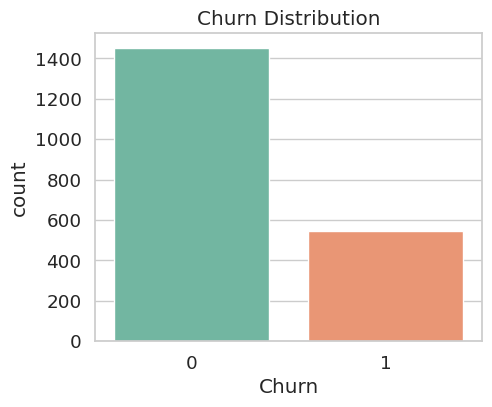

Churn distribution plotted


In [9]:
# ================================
# 6. Churn Distribution
# ================================

plt.figure(figsize=(5,4))
sns.countplot(x="Churn", data=df, palette="Set2")
plt.title("Churn Distribution")
plt.show()

print("Churn distribution plotted")


Numeric Feature Distributions

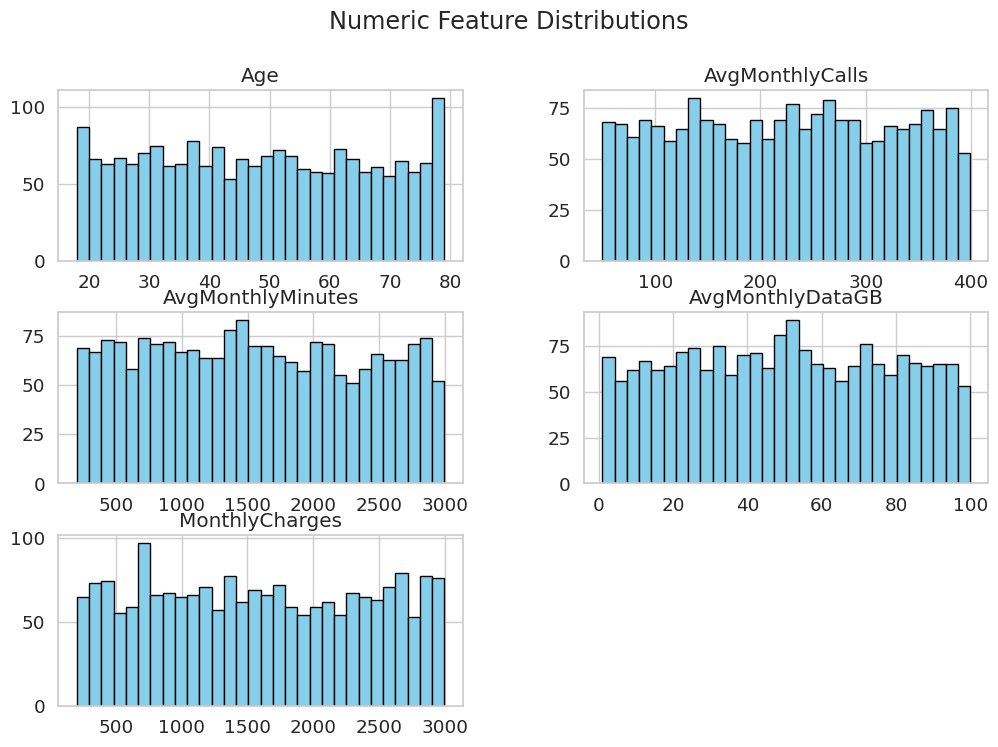

In [10]:
# ================================
# 7. Numeric Feature Distributions
# ================================

num_cols = ["Age","AvgMonthlyCalls","AvgMonthlyMinutes","AvgMonthlyDataGB","MonthlyCharges"]

df[num_cols].hist(bins=30, figsize=(12,8), color="skyblue", edgecolor="black")
plt.suptitle("Numeric Feature Distributions")
plt.show()


Correlation Heatmap

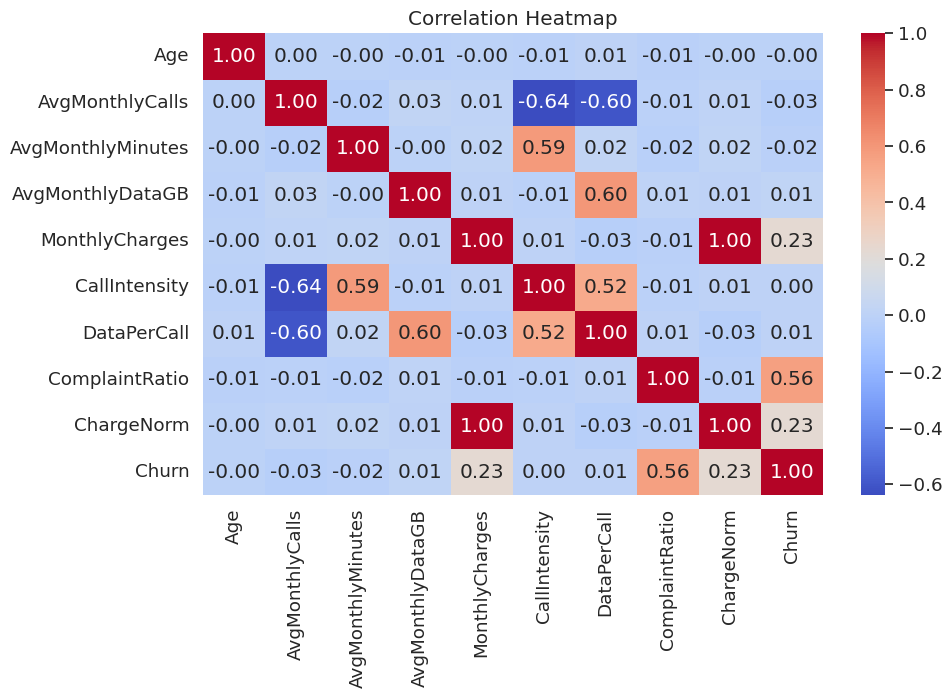

In [11]:
# ================================
# 8. Correlation Heatmap
# ================================

plt.figure(figsize=(10,6))
sns.heatmap(df[num_cols + ["CallIntensity","DataPerCall","ComplaintRatio","ChargeNorm","Churn"]].corr(),
            annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


Categorical vs Churn

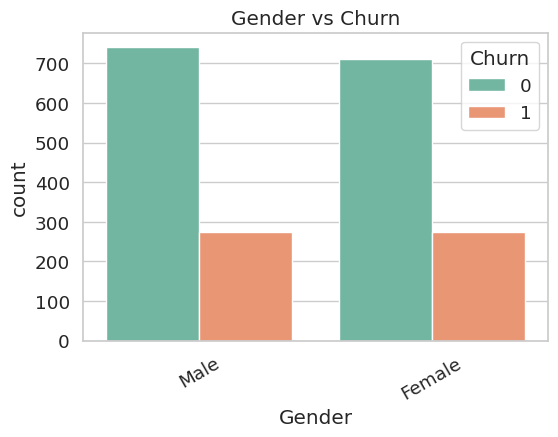

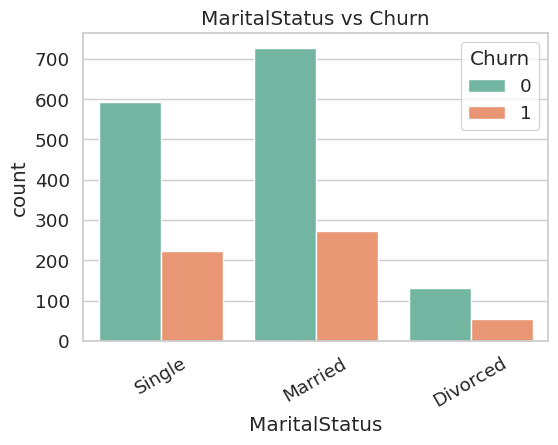

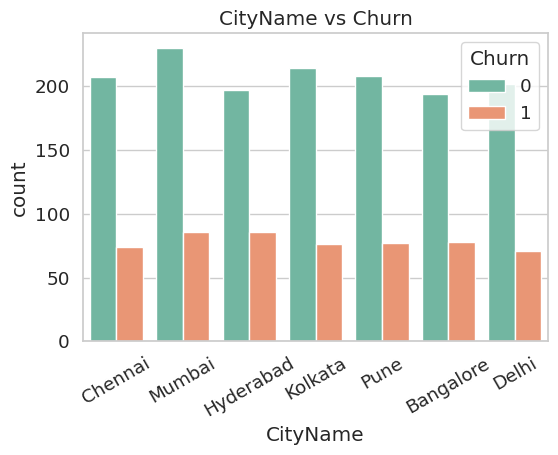

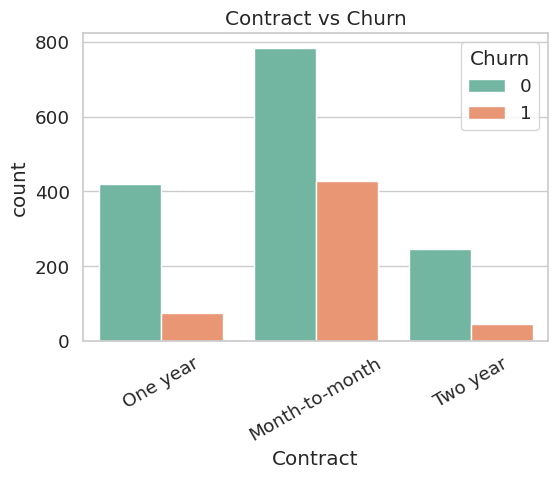

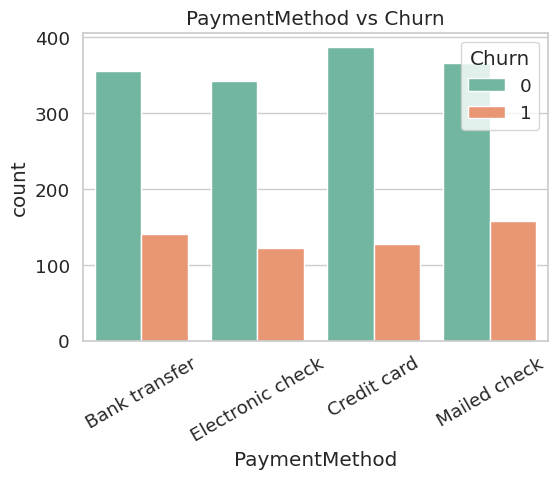

In [12]:
# ================================
# 9. Categorical Features vs Churn
# ================================

cat_cols = ["Gender","MaritalStatus","CityName","Contract","PaymentMethod"]

for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, hue="Churn", data=df, palette="Set2")
    plt.title(f"{col} vs Churn")
    plt.xticks(rotation=30)
    plt.show()


Train-Test Split

In [13]:
# ================================
# 10. Train-Test Split
# ================================

X = df.drop(columns=["CustomerID","Churn"])
y = df["Churn"]

categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)


Train shape: (1400, 18)  Test shape: (600, 18)


Preprocessing

In [14]:
# ================================
# 11. Preprocessing
# ================================

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

# This "fits" the preprocessor on training data
X_train_transformed = preprocessor.fit_transform(X_train)

# Then you can transform test (or new) data
X_test_transformed = preprocessor.transform(X_test)

# ================================
# 12. Define full features list (important!)
# ================================
features = [
    # numeric
    "Age", "AvgMonthlyCalls",
    "AvgMonthlyMinutes", "AvgMonthlyDataGB", "SupportTicketsLast6mo", "ComplaintsFiled",
    "MonthlyCharges","CustomerSatisfaction"

    # engineered
    "ComplaintRatio", "DataPerCall", "ChargeNorm", "CallIntensity",

    # categorical
    "Gender", "CityName", "Contract", "MaritalStatus", "InternationalPlan", "PaymentMethod"
]

Class Distribution Before SMOTE

/tmp/ipython-input-1639491868.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette="Set2")


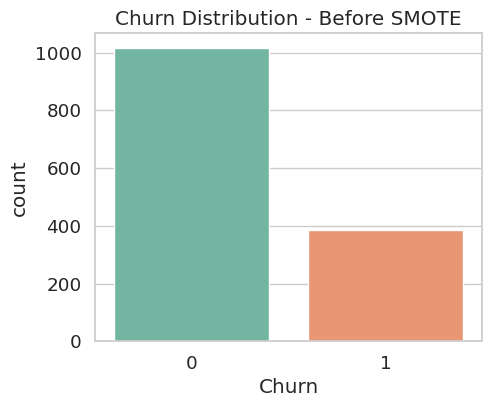

Churn
0    1016
1     384
Name: count, dtype: int64


In [15]:
# ================================
# 12. Class Distribution Before SMOTE
# ================================

plt.figure(figsize=(5,4))
sns.countplot(x=y_train, palette="Set2")
plt.title("Churn Distribution - Before SMOTE")
plt.show()

print(y_train.value_counts())


Apply SMOTE

/tmp/ipython-input-3714918335.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_res, palette="Set2")


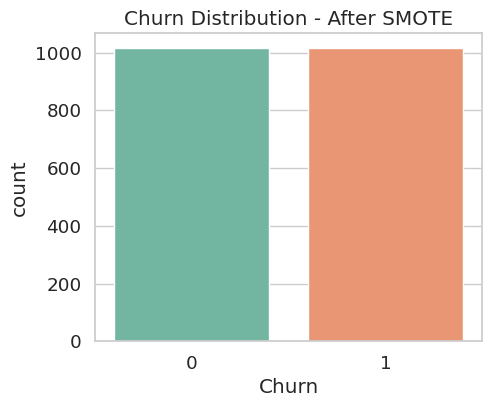

Churn
0    1016
1    1016
Name: count, dtype: int64


In [16]:
# ================================
# 13. Apply SMOTE
# ================================

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_transformed, y_train)

plt.figure(figsize=(5,4))
sns.countplot(x=y_train_res, palette="Set2")
plt.title("Churn Distribution - After SMOTE")
plt.show()

print(pd.Series(y_train_res).value_counts())


Model Definition and Training

Random Forest

In [17]:
# ================================
# 14. Random Forest (with Hyperparameter Tuning)
# ================================
from sklearn.model_selection import GridSearchCV

param_grid_rf = {
    "n_estimators": [200, 300],
    "max_depth": [10, 15, None],
    "min_samples_split": [2, 5],
    "class_weight": ["balanced"]
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=3,
    scoring="accuracy",
    n_jobs=-1
)
grid_rf.fit(X_train_res, y_train_res)

rf_best = grid_rf.best_estimator_

print("Random Forest trained with best params")
print("Best RF Params:", grid_rf.best_params_)
print("Best RF CV Score:", grid_rf.best_score_)



Random Forest trained with best params
Best RF Params: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 300}
Best RF CV Score: 0.9532700371382218


XGBoost

In [18]:

# ================================
# 15. XGBoost (with Hyperparameter Tuning)
# ================================
param_grid_xgb = {
    "n_estimators": [200, 300],
    "max_depth": [4, 6],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 0.9],
    "colsample_bytree": [0.8, 1.0]
}

grid_xgb = GridSearchCV(
    XGBClassifier(eval_metric="logloss", random_state=42, use_label_encoder=False),
    param_grid_xgb,
    cv=3,
    scoring="accuracy",
    n_jobs=-1
)
grid_xgb.fit(X_train_res, y_train_res)

xgb_best = grid_xgb.best_estimator_

print("XGBoost trained with best params")
print("Best XGB Params:", grid_xgb.best_params_)
print("Best XGB CV Score:", grid_xgb.best_score_)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:54:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost trained with best params
Best XGB Params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8}
Best XGB CV Score: 0.9542489640658292


Stacking Ensemble

In [19]:
# ================================
# 16. Stacking Ensemble (with Tuned Models)
# ================================
stack = VotingClassifier(
    estimators=[("rf", rf_best), ("xgb", xgb_best)], voting="soft"
)

print("Stacking Ensemble defined with tuned RF & XGB")


Stacking Ensemble defined with tuned RF & XGB


In [20]:
# ================================
# 18. Define Models Dictionary (Cleaned)
# ================================
rf = RandomForestClassifier(
    n_estimators=300, max_depth=15, class_weight="balanced", random_state=42
)

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,   #  prevents warning
    eval_metric="logloss"      #  recommended metric
)


stack = StackingClassifier(
    estimators=[("rf", rf), ("xgb", xgb)],
    final_estimator=LogisticRegression(),
    n_jobs=-1
)

models = {
    "Random Forest": rf,
    "XGBoost": xgb,
    "Stacking Ensemble": stack
}
print("Models dictionary defined")


Models dictionary defined


In [21]:
# ================================
# 22. Refit Models on Training Data
# ================================
for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    print(f"{name} fitted successfully on training data")


Random Forest fitted successfully on training data


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:54:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost fitted successfully on training data
Stacking Ensemble fitted successfully on training data


### Other Models Tried (but not kept)

We also experimented with **Logistic Regression** and **Support Vector Machine (SVM)** as baseline models.  
However, these models did not perform as well as Random Forest and XGBoost in terms of accuracy, recall, and ROC-AUC on this dataset.  

- Logistic Regression struggled to capture the non-linear feature interactions.  
- SVM performed reasonably but was computationally expensive on this dataset size.  

Therefore, we focused on **Random Forest, XGBoost, and the Stacking Ensemble**, which consistently achieved higher and more stable performance.


Cross-Validation Check

In [22]:
# =====================
# Cross-Validation Check
# =====================
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import xgboost as xgb
xgb.set_config(verbosity=0)  # silence XGBoost warnings

print("Cross-Validation Results:")
print("========================================")
for name, model in models.items():
    scores = cross_val_score(model, X_train_res, y_train_res, cv=5, scoring="accuracy")
    print(f"{name:<20} CV Accuracy: {scores.mean():.4f} (+/- {scores.std():.4f})")


Cross-Validation Results:
Random Forest        CV Accuracy: 0.9562 (+/- 0.0327)
XGBoost              CV Accuracy: 0.9616 (+/- 0.0192)
Stacking Ensemble    CV Accuracy: 0.9611 (+/- 0.0211)


/tmp/ipython-input-616265743.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(cv_results.values(), labels=cv_results.keys(), patch_artist=True)


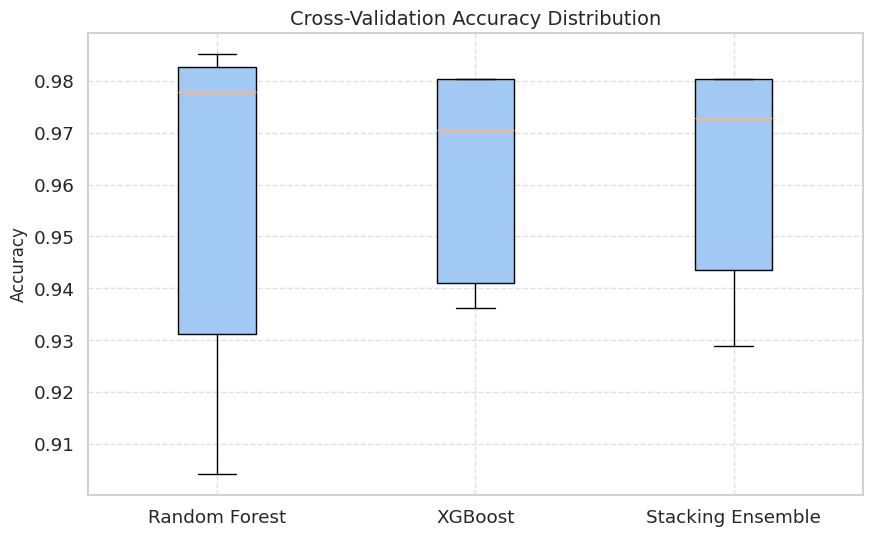

In [25]:
# =====================
# Cross-Validation Results Visualization
# =====================
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

# Calculate CV scores (re-calculating here for self-contained cell)
rf_cv = cross_val_score(models["Random Forest"], X_train_res, y_train_res, cv=5, scoring="accuracy")
xgb_cv = cross_val_score(models["XGBoost"], X_train_res, y_train_res, cv=5, scoring="accuracy")
stack_cv = cross_val_score(models["Stacking Ensemble"], X_train_res, y_train_res, cv=5, scoring="accuracy")


# Collect CV scores into a dictionary
cv_results = {
    "Random Forest": rf_cv,
    "XGBoost": xgb_cv,
    "Stacking Ensemble": stack_cv
}

# Plot boxplots
plt.figure(figsize=(10,6))
plt.boxplot(cv_results.values(), labels=cv_results.keys(), patch_artist=True)
plt.title("Cross-Validation Accuracy Distribution", fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

Train Models

In [26]:
# ================================
# 20. Retrain Final Models with Best Params
# ================================
rf_best = grid_rf.best_estimator_
xgb_best = grid_xgb.best_estimator_

stack_best = StackingClassifier(
    estimators=[("rf", rf_best), ("xgb", xgb_best)],
    final_estimator=LogisticRegression(),
    passthrough=True, n_jobs=-1
)

final_models = {
    "Random Forest": rf_best,
    "XGBoost": xgb_best,
    "Stacking Ensemble": stack_best
}

for name, model in final_models.items():
    model.fit(X_train_res, y_train_res)
    print(f"{name} retrained with best hyperparameters")


Random Forest retrained with best hyperparameters
XGBoost retrained with best hyperparameters
Stacking Ensemble retrained with best hyperparameters


Evaluation Function

In [27]:
# ================================
# 21. Model Evaluation Function
# ================================
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix
)

def evaluate_model(model, X_train, y_train, X_test, y_test, name):
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metrics
    metrics = {
        "Accuracy": accuracy_score(y_test, y_test_pred),
        "Precision": precision_score(y_test, y_test_pred),
        "Recall": recall_score(y_test, y_test_pred),
        "F1": f1_score(y_test, y_test_pred),
        "ROC-AUC": roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    }


    print("="*50)
    print(f" Results for {name} ")
    print("="*50)
    print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
    print(f"Test Accuracy : {metrics['Accuracy']:.4f}")
    print(f"Precision     : {metrics['Precision']:.4f}")
    print(f"Recall        : {metrics['Recall']:.4f}")
    print(f"F1 Score      : {metrics['F1']:.4f}")
    print(f"ROC-AUC       : {metrics['ROC-AUC']:.4f}")
    print()

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return metrics


 Results for Random Forest 
Train Accuracy: 0.9995
Test Accuracy : 0.9200
Precision     : 0.8671
Recall        : 0.8354
F1 Score      : 0.8509
ROC-AUC       : 0.9740



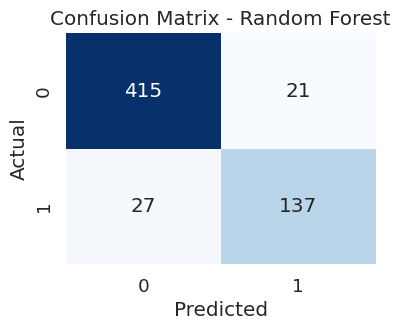

 Results for XGBoost 
Train Accuracy: 1.0000
Test Accuracy : 0.9517
Precision     : 0.9299
Recall        : 0.8902
F1 Score      : 0.9097
ROC-AUC       : 0.9864



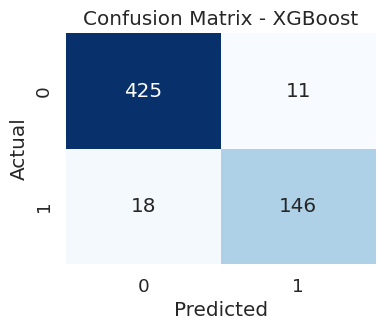

 Results for Stacking Ensemble 
Train Accuracy: 0.9990
Test Accuracy : 0.9517
Precision     : 0.9299
Recall        : 0.8902
F1 Score      : 0.9097
ROC-AUC       : 0.9888



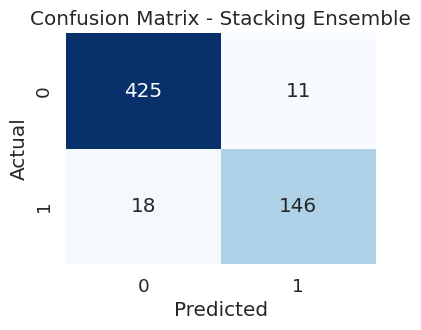

Final Comparison Table:


,Accuracy,Precision,Recall,F1,ROC-AUC
Random Forest,0.920000,0.867089,0.835366,0.850932,0.973973
XGBoost,0.951667,0.929936,0.890244,0.909657,0.986392
Stacking Ensemble,0.951667,0.929936,0.890244,0.909657,0.988812


In [28]:
# ================================
# 20. Evaluate All Models
# ================================

results = {}
for name, model in final_models.items():
    results[name] = evaluate_model(model, X_train_res, y_train_res, X_test_transformed, y_test, name)

results_df = pd.DataFrame(results).T
print("Final Comparison Table:")
display(results_df)

Model Comparison Chart

<Figure size 800x500 with 0 Axes>

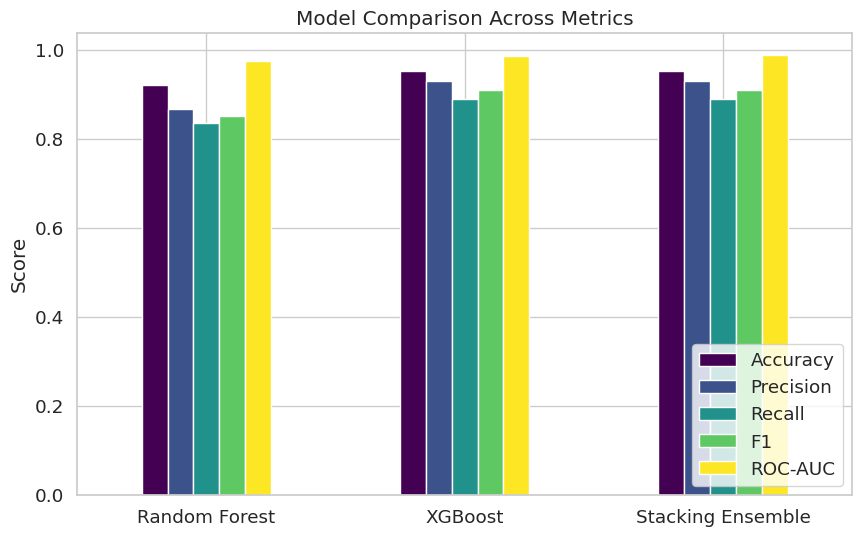

In [29]:
# ================================
# Model Comparison Bar Chart
# ================================

results_df = pd.DataFrame(results).T  # already created in eval step

plt.figure(figsize=(8,5))
results_df[["Accuracy","Precision","Recall","F1","ROC-AUC"]].plot(
    kind="bar", figsize=(10,6), colormap="viridis"
)
plt.title("Model Comparison Across Metrics")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.show()


ROC Curves

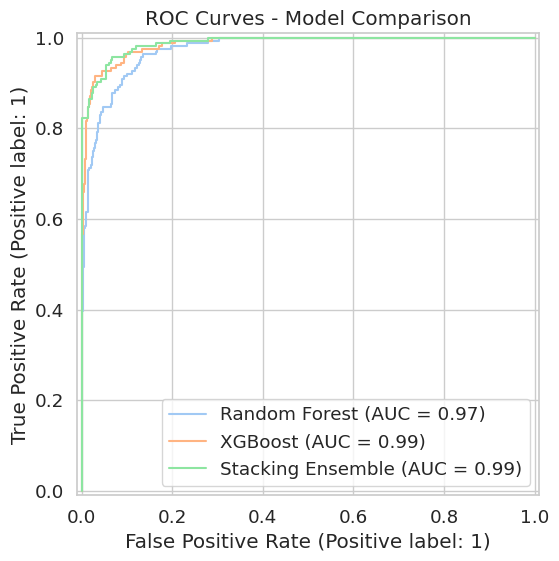

In [30]:
# ================================
# ROC Curves for All Models
# ================================

plt.figure(figsize=(7,6))

for name, model in final_models.items():
    RocCurveDisplay.from_estimator(
        model, X_test_transformed, y_test, name=name, ax=plt.gca()
    )

plt.title("ROC Curves - Model Comparison")
plt.show()

Precision-Recall Curves

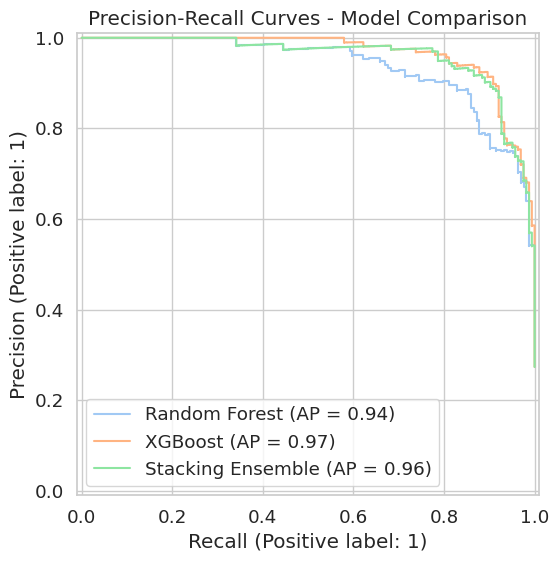

In [31]:
# ================================
# Precision-Recall Curves
# ================================

from sklearn.metrics import PrecisionRecallDisplay

plt.figure(figsize=(7,6))

for name, model in models.items():
    PrecisionRecallDisplay.from_estimator(
        model, X_test_transformed, y_test, name=name, ax=plt.gca()
    )

plt.title("Precision-Recall Curves - Model Comparison")
plt.show()


Feature Importances

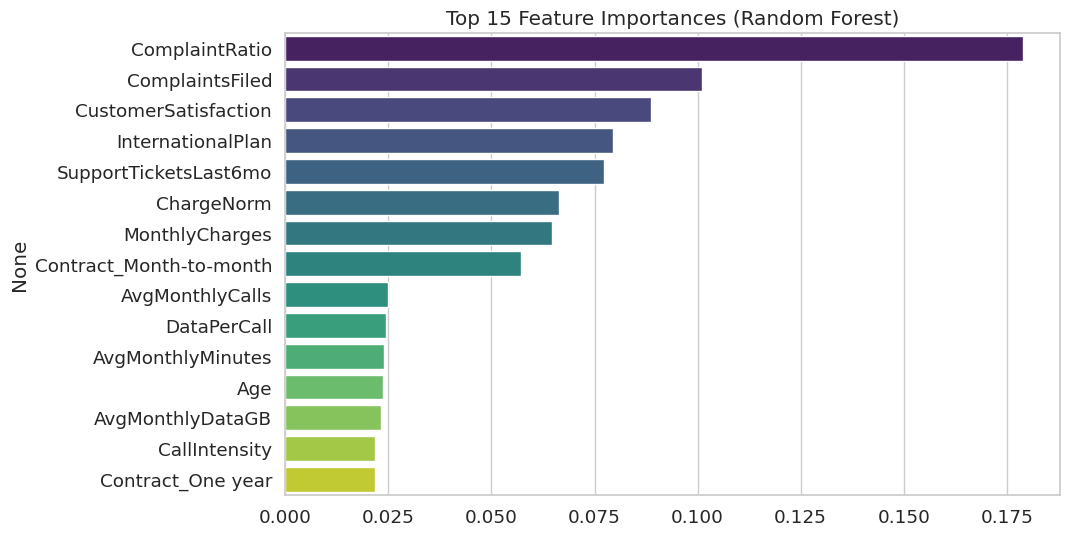

In [32]:
# ================================
# 19. Feature Importances
# ================================

ohe = preprocessor.named_transformers_["cat"]
cat_features = ohe.get_feature_names_out(categorical_cols)
all_features = numeric_cols + list(cat_features)

importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=all_features).sort_values(ascending=False)[:15]

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette="viridis")
plt.title("Top 15 Feature Importances (Random Forest)")
plt.show()


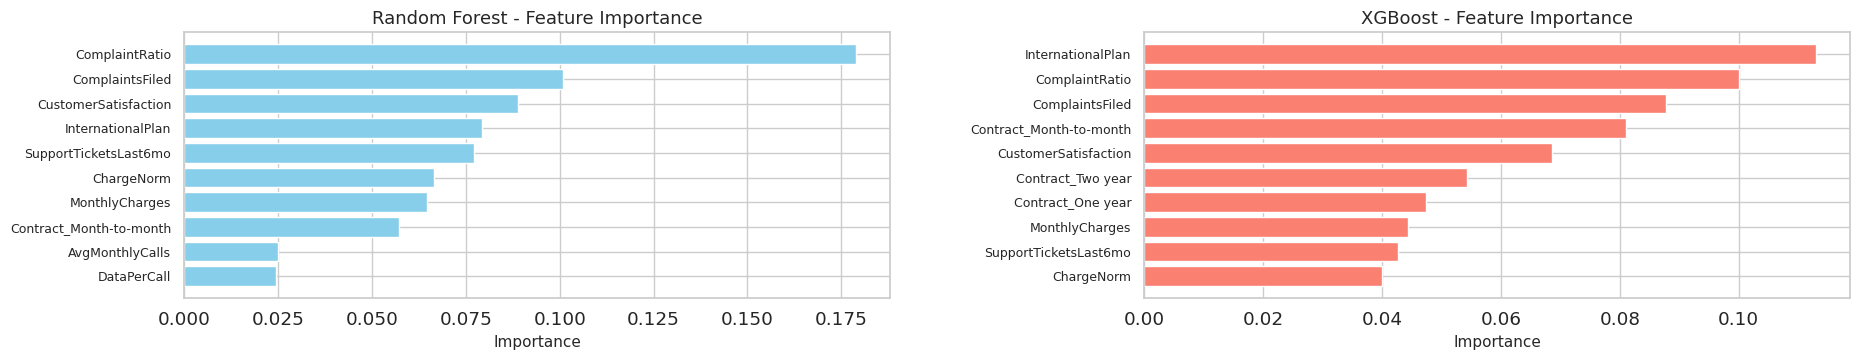

In [33]:
# =====================
# Feature Importance Comparison (Top 10 Features)
# =====================
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(20,5))

# --- Random Forest ---
importances_rf = models["Random Forest"].feature_importances_
indices_rf = np.argsort(importances_rf)[-10:]  # Top 10 features

ohe = preprocessor.named_transformers_["cat"]
cat_features = ohe.get_feature_names_out(categorical_cols)
all_features = numeric_cols + list(cat_features)

axes[0].barh(range(len(indices_rf)), importances_rf[indices_rf], color='skyblue')
axes[0].set_yticks(range(len(indices_rf)))
axes[0].set_yticklabels(np.array(all_features)[indices_rf], fontsize=9)
axes[0].set_title("Random Forest - Feature Importance", fontsize=13)
axes[0].set_xlabel("Importance", fontsize=11)

# --- XGBoost ---
importances_xgb = models["XGBoost"].feature_importances_
indices_xgb = np.argsort(importances_xgb)[-10:]  # Top 10 features
axes[1].barh(range(len(indices_xgb)), importances_xgb[indices_xgb], color='salmon')
axes[1].set_yticks(range(len(indices_xgb)))
axes[1].set_yticklabels(np.array(all_features)[indices_xgb], fontsize=9)
axes[1].set_title("XGBoost - Feature Importance", fontsize=13)
axes[1].set_xlabel("Importance", fontsize=11)

plt.tight_layout(pad=4)
plt.show()

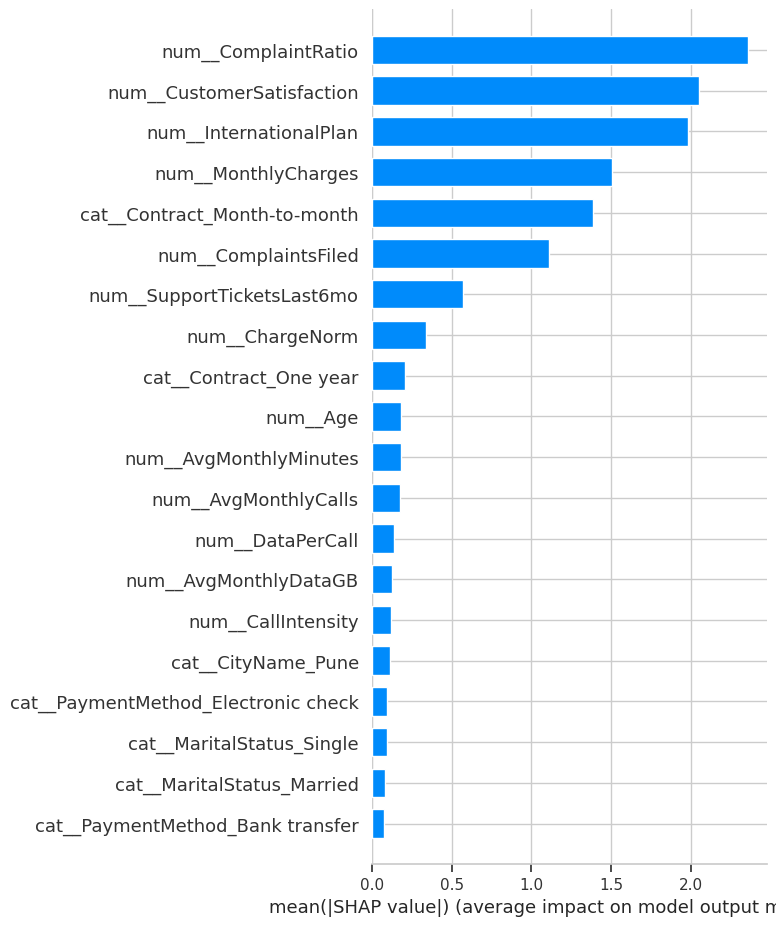

In [35]:
# =====================
# Feature Importance with SHAP
# =====================
import shap

# Check if models dictionary is defined
if 'models' in globals() and "XGBoost" in models:
    # Use the trained XGBoost model from the models dictionary
    explainer = shap.TreeExplainer(models["XGBoost"])
    X_test_trans = preprocessor.transform(X_test)
    shap_values = explainer.shap_values(X_test_trans)

    shap.summary_plot(shap_values, X_test_trans, feature_names=preprocessor.get_feature_names_out(), plot_type="bar")
else:
    print("Error: 'models' dictionary or 'XGBoost' model not found. Please run the model training cells.")

Interactive Model

In [36]:
# ================================
# Final Model Selection
# ================================

# Best model chosen (Stacking Ensemble had highest CV)
best_model = stack

print("Best model (Stacking Ensemble) is ready for predictions")


Best model (Stacking Ensemble) is ready for predictions


In [37]:
# Ensure same column order as training
df_input = df_input[features]

In [47]:
# ================================
# Interactive Customer Input Prediction (clean + auto-engineered + mappings)
# ================================
import pandas as pd

# Full features list (MUST match training)
features = [
    "Age", "AvgMonthlyCalls", "AvgMonthlyMinutes", "AvgMonthlyDataGB",
    "SupportTicketsLast6mo", "ComplaintsFiled", "MonthlyCharges",
    "CustomerSatisfaction", "InternationalPlan",  # numeric
    "ComplaintRatio", "DataPerCall", "ChargeNorm", "CallIntensity",  # engineered
    "Gender", "CityName", "Contract", "MaritalStatus", "PaymentMethod"  # categorical
]

# Expanded mappings (with shortcuts + variations)
gender_map = {
    "m": "Male", "male": "Male", "f": "Female", "female": "Female"
}
city_map = {
    "del": "Delhi", "delhi": "Delhi",
    "mum": "Mumbai", "mumbai": "Mumbai",
    "blr": "Bangalore", "bangalore": "Bangalore",
    "chn": "Chennai", "chennai": "Chennai",
    "hyd": "Hyderabad", "hyderabad": "Hyderabad",
    "pune": "Pune",
    "kol": "Kolkata", "kolkata": "Kolkata"
}
contract_map = {
    "mtm": "Month-to-month", "month to month": "Month-to-month", "month-to-month": "Month-to-month",
    "1y": "One year", "one year": "One year",
    "2y": "Two year", "two year": "Two year"
}
marital_map = {
    "s": "Single", "single": "Single",
    "m": "Married", "married": "Married",
    "d": "Divorced", "divorced": "Divorced"
}
payment_map = {
    "cc": "CreditCard", "credit": "CreditCard", "creditcard": "CreditCard",
    "dc": "DebitCard", "debit": "DebitCard", "debitcard": "DebitCard",
    "upi": "Upi",
    "oth": "Other", "other": "Other"
}

# Get training max charge if df exists
train_max_charge = df["MonthlyCharges"].max() if "df" in globals() and not df.empty else None

customer_data = []

while True:
    print("\nEnter customer details (type 'done' to finish):")
    gender_in = input("Gender (Male/Female): ").strip().lower()
    if gender_in == "done":
        break
    gender = gender_map.get(gender_in, "Male")

    age = int(input("Age (18-80): "))

    city_in = input("City (Delhi/Mumbai/...): ").strip().lower()
    city = city_map.get(city_in, "Delhi")

    monthly_charges = float(input("Monthly Charges: "))

    contract_in = input("Contract (Month-to-month/One year/Two year): ").strip().lower()
    contract = contract_map.get(contract_in, "Month-to-month")

    marital_in = input("Marital Status (Single/Married/Divorced): ").strip().lower()
    marital_status = marital_map.get(marital_in, "Single")

    intl_plan = input("International Plan (Yes/No): ").strip().lower()
    intl_plan_num = 1 if intl_plan in ["yes", "y", "1"] else 0

    satisfaction = int(input("Customer Satisfaction (1-5): "))
    support_tickets = int(input("Support Tickets Last 6 Months: "))
    complaints = int(input("Complaints Filed: "))
    tenure = int(input("Tenure (months): "))
    total_charges = float(input("Total Charges: "))
    avg_calls = float(input("Avg Monthly Calls: "))
    avg_minutes = float(input("Avg Monthly Minutes: "))
    avg_data = float(input("Avg Monthly Data (GB): "))

    payment_in = input("Payment Method (CreditCard/DebitCard/Upi/Other): ").strip().lower()
    payment_method = payment_map.get(payment_in, "Other")

    # Engineered features
    call_intensity = avg_minutes / (avg_calls if avg_calls > 0 else 1)
    data_per_call = avg_data / (avg_calls if avg_calls > 0 else 1)
    complaint_ratio = complaints / (support_tickets if support_tickets > 0 else 1)
    charge_norm = monthly_charges / (train_max_charge if train_max_charge else monthly_charges)

    customer_data.append({
        "Age": age,
        "AvgMonthlyCalls": avg_calls,
        "AvgMonthlyMinutes": avg_minutes,
        "AvgMonthlyDataGB": avg_data,
        "SupportTicketsLast6mo": support_tickets,
        "ComplaintsFiled": complaints,
        "MonthlyCharges": monthly_charges,
        "CustomerSatisfaction": satisfaction,
        "InternationalPlan": intl_plan_num,

        "ComplaintRatio": complaint_ratio,
        "DataPerCall": data_per_call,
        "ChargeNorm": charge_norm,
        "CallIntensity": call_intensity,

        "Gender": gender,
        "CityName": city,
        "Contract": contract,
        "MaritalStatus": marital_status,
        "PaymentMethod": payment_method
    })

    another = input("Add another customer? (yes/no): ").strip().lower()
    if another != "yes":
        break

# Convert to DataFrame
df_input = pd.DataFrame(customer_data)

# Ensure correct column order
df_input = df_input[features]

# Preprocess
X_input = preprocessor.transform(df_input)

# Predictions
if "best_model" in globals():
    preds = best_model.predict(X_input)
    probs = best_model.predict_proba(X_input)[:, 1]

    df_input["Churn Prediction"] = preds
    df_input["Churn Probability"] = probs.round(3)

    print("\n=== Customer Predictions ===")
    display(df_input[["Gender", "Age", "CityName", "MonthlyCharges", "Contract",
                      "Churn Prediction", "Churn Probability"]])
else:
    print("Error: Best model is not defined. Please run training first.")



Enter customer details (type 'done' to finish):
Gender (Male/Female): male
Age (18-80): 24
City (Delhi/Mumbai/...): del
Monthly Charges: 200
Contract (Month-to-month/One year/Two year): one year
Marital Status (Single/Married/Divorced): single
International Plan (Yes/No): y
Customer Satisfaction (1-5): 4
Support Tickets Last 6 Months: 3
Complaints Filed: 1
Tenure (months): 12
Total Charges: 2400
Avg Monthly Calls: 40
Avg Monthly Minutes: 80
Avg Monthly Data (GB): 30
Payment Method (CreditCard/DebitCard/Upi/Other): upi
Add another customer? (yes/no): no

=== Customer Predictions ===


,Gender,Age,CityName,MonthlyCharges,Contract,Churn Prediction,Churn Probability
0,Male,24,Delhi,200.0,One year,0,0.015


Save Models

In [49]:
# ================================
# 20. Save Models
# ================================

# Save the fitted models from the final_models dictionary
joblib.dump(final_models["Random Forest"], "rf_model.pkl")
joblib.dump(final_models["XGBoost"], "xgb_model.pkl")
joblib.dump(final_models["Stacking Ensemble"], "stack_model.pkl")

print("Models saved successfully")

Models saved successfully
